In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Dropout


In [107]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [108]:
df= pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [109]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [110]:
df.dropna(inplace=True)

In [111]:
df.head(10)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


In [112]:
df.reset_index(inplace=True)

In [113]:
df.dtypes

index      int64
id         int64
title     object
author    object
text      object
label      int64
dtype: object

### Title Length Statistics

In [114]:
title_len= df.title.str.split().str.len()
print(title_len.describe())

count    18285.000000
mean        12.524255
std          4.023303
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64


In [115]:
df.label.value_counts()

0    10361
1     7924
Name: label, dtype: int64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

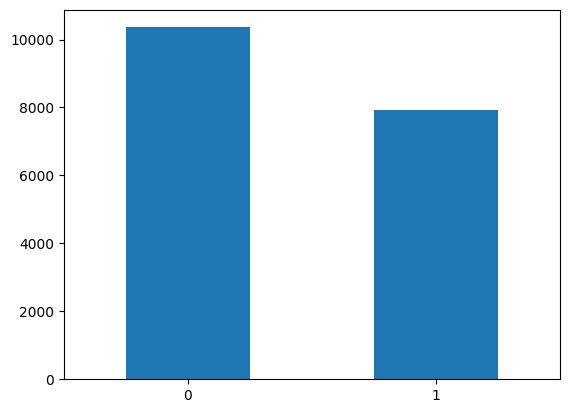

In [116]:
df.label.value_counts().plot(kind='bar')
plt.xticks(rotation=0)

# Data Preprocessing

In [117]:
X = df['title']
Y= df['label']

## Cleaning the input data

In [118]:
ps= PorterStemmer()
corpus= []

for i in range(len(X)):
    text = X[i]
    text = re.sub('[^a-zA-Z]',' ', text)
    text= text.lower()
    text = text.split()
    text = [ps.stem(t) for t in text if t not in stopwords.words('english')]
    corpus.append(' '.join(text))

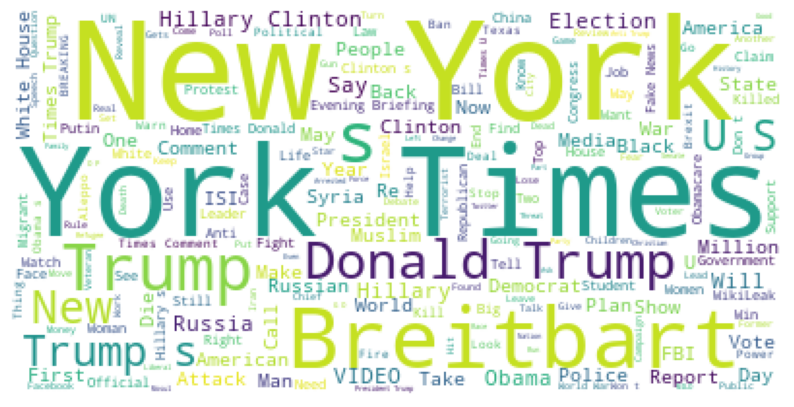

In [119]:
from wordcloud import WordCloud, STOPWORDS

#initializing world cloud
word= WordCloud(background_color='white')
text= word.generate(' '.join(df['title']))
#plotting wordcloud
plt.figure(figsize=(10,20))
plt.imshow(text)
plt.axis('off')
plt.show()

In [120]:
# Prepping data for 
vocab_size = 5000      
sent_len = 20

embded_sequence= [one_hot(x, vocab_size) for x in corpus]
embded_sequence= pad_sequences(embded_sequence, maxlen= sent_len)
embded_sequence[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3702,
        249, 3216, 4100, 4424, 1862, 4281, 3431, 2621, 1782])

In [121]:
#creating the model
no_output_features= 40

model= Sequential(
    [
        Embedding(vocab_size, no_output_features, input_length= sent_len),
        Dropout(0.5),
        LSTM(100),
        Dropout(0.5),
        Dense(1, activation='sigmoid')

    ]
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout_8 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________


In [122]:
len(embded_sequence), Y.shape

(18285, (18285,))

In [123]:
X= np.array(embded_sequence)
Y= np.array(Y)

In [124]:
X.shape, Y.shape

((18285, 20), (18285,))

In [125]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.33, random_state=42)

In [126]:
#Training the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=64, epochs=10)

Epoch 1/10
192/192 [==============================] - 13s 45ms/step - loss: 0.3562 - accuracy: 0.8315 - val_loss: 0.2015 - val_accuracy: 0.9147
Epoch 2/10
192/192 [==============================] - 7s 36ms/step - loss: 0.1651 - accuracy: 0.9336 - val_loss: 0.1918 - val_accuracy: 0.9175
Epoch 3/10
192/192 [==============================] - 8s 40ms/step - loss: 0.1297 - accuracy: 0.9485 - val_loss: 0.1956 - val_accuracy: 0.9185
Epoch 4/10
192/192 [==============================] - 8s 40ms/step - loss: 0.1043 - accuracy: 0.9612 - val_loss: 0.2271 - val_accuracy: 0.9163
Epoch 5/10
192/192 [==============================] - 8s 40ms/step - loss: 0.0916 - accuracy: 0.9657 - val_loss: 0.2436 - val_accuracy: 0.9145
Epoch 6/10
192/192 [==============================] - 8s 40ms/step - loss: 0.0740 - accuracy: 0.9742 - val_loss: 0.2324 - val_accuracy: 0.9095
Epoch 7/10
192/192 [==============================] - 8s 39ms/step - loss: 0.0632 - accuracy: 0.9777 - val_loss: 0.2767 - val_accuracy: 0.914

In [127]:
yhat= model.predict(X_test)
yhat= (yhat>=0.5)

189/189 [==============================] - 2s 9ms/step


In [128]:
confusion_matrix(yhat, Y_test)

array([[3114,  227],
       [ 305, 2389]], dtype=int64)

In [129]:
score= accuracy_score(yhat, Y_test)
score

0.911847555923778

In [130]:
model.get_weights()[0]

array([[-0.01966399,  0.01166762,  0.01741973, ...,  0.00245305,
        -0.01395317,  0.03948966],
       [ 0.01475252,  0.04671486,  0.06694395, ..., -0.04344733,
         0.03461927,  0.00413239],
       [ 0.01107333,  0.05798729,  0.01528937, ...,  0.00285084,
         0.0668159 , -0.02413815],
       ...,
       [-0.08285832,  0.04277285,  0.1312429 , ...,  0.02969468,
         0.11921085,  0.08145292],
       [-0.00757599, -0.00474757, -0.03076191, ...,  0.03679234,
        -0.07967346, -0.07516731],
       [ 0.06475656, -0.06316427, -0.0473045 , ..., -0.05379375,
         0.00120117, -0.06877196]], dtype=float32)